# Retrieval‑Augmented Generation (RAG) 

## О ноутбуке

В этом ноутбуке мы реализуем ассистента для ответов на вопросы на основе русской Википедии с помощью RAG, который помимо всего прочего может ходить в интернет за дополнительной информацией. Вся логика системы намеренно написана самостоятельно без специализорованных библиотек. Ноутбук состоит из нескольких логических компонент:

1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски
3. Ранжирование документов по релевантности и генерация ответа
4. Поиск по интернету
5. Ответы, учитывающие контекст

## О данных

В качестве датасета мы будем использовать [дамп Википедии](https://huggingface.co/datasets/omarkamali/wikipedia-monthly) 1 января 2026 года, который был предварительно выгружен в виде csv файла.

In [43]:
import os
from typing import List, Optional, Tuple, Any, Dict
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel

from tqdm import tqdm
import pickle
import json

from ddgs import DDGS

In [3]:
# Кодом ниже можно скачать полный датасет

# data_files = {
#     "train": "hf://datasets/omarkamali/wikipedia-monthly/20260101/ru/train/train_part_*.parquet"
# }

# dataset = load_dataset("parquet", data_files=data_files, split="train")
# dataset

In [4]:
# Код ниже очищает текста от "\xa0"

# def clean_text(example):
#     example["text"] = example["text"].replace("\xa0", " ")
#     return example

# dataset = dataset.map(clean_text)

Исходный датасет содержит более двух миллионов статей из русскоязычной википедии. Однако для ускорения работы мы будем работать только с 1000 статьями. Они были предварительно выгружены, очищены и сохранены в csv файл.

In [5]:
dataset = load_dataset("csv", data_files="/kaggle/input/datasets/romashinkarev/wikipedia-ru-10k-20260101/wikipedia_10k_20260101.csv")["train"]

Generating train split: 0 examples [00:00, ? examples/s]

Пример текста:

In [6]:
print(dataset[60]["text"][:500])

Ки́ров (до 5 декабря 1934 года — Вя́тка, с 1457 по 1780 год такжеВ указанный период (1457—1780) в официально опубликованных нормативно-правовых актах Русского царства и Российской империи город неоднократно именовался Вяткой:

А в Вятке прежде благословенного епископа укрепихом и впредь епископу быти.

<…> велеть из тех приказов в те городы послать великого государя грамоты <…> на Вятку…

<…> да к Вятке 4 пригородка, всего 30 городов.

Провинция: Вятская. Вятка…

<…> оставить в каждом городе по 


Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

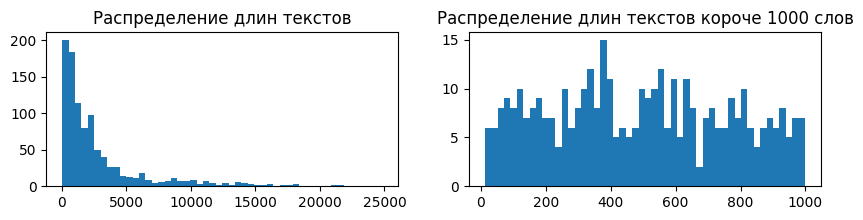

In [7]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 1000], bins=50)
plt.title('Распределение длин текстов короче 1000 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы не потерять важную информацию при векторизации текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Загрузка модели

В качестве основы для ассистента возьмем модель [`Qwen/Qwen2.5-3B-Instruct`](https://huggingface.co/Qwen/Qwen2.5-3B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

Проверим как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [8]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

generation_tokenizer = AutoTokenizer.from_pretrained(model_name)

generation_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

2026-02-15 19:16:54.612411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771183014.784721      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771183014.832456      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771183015.247818      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771183015.247848      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771183015.247851      55 computation_placer.cc:177] computation placer alr

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [9]:
def generate_answer(question, generation_model, generation_tokenizer, max_new_tokens=512, temperature=0.7, top_p=0.9):   
    messages = [{"role": "user", "content": question}]
    
    text = generation_tokenizer.apply_chat_template(messages, 
                                                    tokenize=False, 
                                                    add_generation_prompt=True)
    inputs = generation_tokenizer(text, return_tensors="pt").to(generation_model.device)

    prompt_len = inputs["input_ids"].shape[-1]
    
    with torch.no_grad():
        out = generation_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=top_p,
            pad_token_id=generation_tokenizer.eos_token_id
        )

    new_tokens = out[0, prompt_len:]
    return generation_tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

In [10]:
query = "Как раньше назывался город Киров?" 
print(f"Запрос: {query}")
answer = generate_answer(query, generation_model, generation_tokenizer)
print(f"Ответ: {answer}")

Запрос: Как раньше назывался город Киров?
Ответ: Город Киров не менял своего названия в течение истории. Он был таковым с момента его основания в 1930 году. Так что ответ на ваш вопрос - название у него не менялось.


In [11]:
query = "Где располагался административный центр войска Донского?" 
print(f"Запрос: {query}")
answer = generate_answer(query, generation_model, generation_tokenizer)
print(f"Ответ: {answer}")

Запрос: Где располагался административный центр войска Донского?
Ответ: Административный центр войска Донского располагался в городе Курган-Уральский (ранее известный как Новочеркасск) в至今为止的俄罗斯。不过，请注意，这一信息可能需要根据最新的历史和地理资料进行验证，因为行政区划可能会有所变动。

在历史上，16-17世纪，这个区域属于喀山楚克（Kazan Chuch），后来在1654年，喀山楚克被沙皇俄国吞并，成为俄罗斯的一部分，并在此基础上形成了现在的顿河畔罗斯托夫州，其首府也相应地从喀山楚克迁移到了罗斯托夫。

如果您需要确切的信息，建议查阅最新的历史或地方志资料。


In [12]:
query = "Среднегодовая температура воздуха в России" 
print(f"Запрос: {query}")
answer = generate_answer(query, generation_model, generation_tokenizer)
print(f"Ответ: {answer}")

Запрос: Среднегодовая температура воздуха в России
Ответ: Среднегодовая температура воздуха в России сильно зависит от региона. В целом, среднегодовая температура по всей стране составляет около -2°C, но это очень общее значение и не учитывает местные особенности.

В северных регионах, таких как Сибирь и Забайкалье, среднегодовая температура ниже нуля. Например, в Якутии она может быть около -20°C.

В центральной России среднегодовая температура обычно находится выше нуля, но колеблется в зависимости от места. Например, в Москве среднегодовая температура составляет около +3°C.

В южных регионах, таких как Средняя Азия и Кавказ, среднегодовая температура выше нуля. Например, в Казани (Удмуртской Республики) она составляет около +5°C.

Это общие данные, и точную информацию о среднегодовой температуре в конкретном регионе лучше всего получить из официальных метеорологических данных для того года, который интересует.


Как мы видим модель либо отвечает неправильно и выдумывает, либо не может точно ответить на вопрос.

## Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции реализован [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

In [13]:
class LSHVectorDB:
    def __init__(self, L: int = 15, k: int = 12, d: int = 1024, seed: int = 42):
        self.L = L
        self.k = k
        self.d = d
        self.seed = seed
        
        np.random.seed(seed)
        
        self.hash_tables = []
        self.normal_vectors = []
        
        for _ in range(L):
            normals = np.random.randn(k, d)
            normals = normals / np.linalg.norm(normals, axis=1, keepdims=True)
            self.normal_vectors.append(normals)
            self.hash_tables.append(defaultdict(list))
        
        self.vectors = []
        self.metadata = []
        
    def _compute_hash(self, vector: np.ndarray, table_idx: int) -> str:
        normals = self.normal_vectors[table_idx]
        hash_bits = (np.dot(normals, vector) >= 0).astype(int)
        return ''.join(hash_bits.astype(str))
    
    def add_vector(self, vector: np.ndarray, metadata: Optional[dict] = None):
        vector = np.array(vector, dtype=np.float32)
        if vector.shape[0] != self.d:
            raise ValueError(f"Вектор должен быть размерности {self.d}, получен {vector.shape[0]}")
        
        vector = vector / np.linalg.norm(vector)
        
        vector_idx = len(self.vectors)
        self.vectors.append(vector)
        self.metadata.append(metadata)
        
        for table_idx in range(self.L):
            hash_key = self._compute_hash(vector, table_idx)
            self.hash_tables[table_idx][hash_key].append(vector_idx)
    
    def search(self, query_vector: np.ndarray, top_k: int = 10) -> List[Tuple[int, float]]:
        query_vector = np.array(query_vector, dtype=np.float32)
        if query_vector.shape[0] != self.d:
            raise ValueError(f"Вектор запроса должен быть размерности {self.d}")
        
        query_vector = query_vector / np.linalg.norm(query_vector)
        
        candidate_indices = set()
        
        for table_idx in range(self.L):
            hash_key = self._compute_hash(query_vector, table_idx)
            if hash_key in self.hash_tables[table_idx]:
                candidate_indices.update(self.hash_tables[table_idx][hash_key])
        
        if len(candidate_indices) == 0:
            return []
        
        candidates = list(candidate_indices)
        candidate_vectors = np.array([self.vectors[i] for i in candidates])
        
        similarities = np.dot(candidate_vectors, query_vector)
        
        sorted_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = [(candidates[i], float(similarities[i])) for i in sorted_indices]
        return results


In [14]:
def load_vector_db(save_dir: str = "vector_db"):    
    with open(f"{save_dir}/lsh_db.pkl", "rb") as f:
        db_data = pickle.load(f)
    
    vector_db = LSHVectorDB(
        L=db_data['L'],
        k=db_data['k'],
        d=db_data['d'],
        seed=db_data['seed']
    )
    vector_db.hash_tables = db_data['hash_tables']
    vector_db.normal_vectors = db_data['normal_vectors']
    vector_db.vectors = db_data['vectors']
    
    with open(f"{save_dir}/metadata.json", "r", encoding="utf-8") as f:
        metadata = json.load(f)
    
    vector_db.metadata = metadata
    
    return vector_db, metadata

## Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется, так как вектор имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

Реализуем [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]` и пересечением между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

In [15]:
class RecursiveTextSplitter:
    def __init__(self, chunk_size: int = 512, chunk_overlap: int = 256):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.separators = ["\n\n", "\n", " ", ""]
        
    def _split_by_separator(self, text: str, separator: str) -> List[str]:
        if separator == "":
            return list(text)
        return text.split(separator)
    
    def _count_words(self, text: str) -> int:
        return len(text.split())
    
    def _split_text_recursive(self, text: str, separators: List[str], 
                              current_chunks: List[str] = None) -> List[str]:
        if current_chunks is None:
            current_chunks = []
        
        if not separators:
            if text.strip():
                current_chunks.append(text.strip())
            return current_chunks
        
        separator = separators[0]
        remaining_separators = separators[1:]
        splits = self._split_by_separator(text, separator)
        
        good_splits = []
        current_split = ""
        
        for split in splits:
            if separator != "":
                test_text = current_split + split + (separator if split != splits[-1] else "")
            else:
                test_text = current_split + split
            
            word_count = self._count_words(test_text) if separator != "" else len(test_text)
            
            if word_count <= self.chunk_size:
                current_split = test_text
            else:
                if current_split.strip():
                    good_splits.append(current_split.strip())
                
                if self._count_words(split) > self.chunk_size if separator != "" else len(split) > self.chunk_size:
                    sub_chunks = self._split_text_recursive(split, remaining_separators, [])
                    good_splits.extend(sub_chunks)
                    current_split = ""
                else:
                    current_split = split + (separator if separator != "" else "")
        
        if current_split.strip():
            good_splits.append(current_split.strip())
        
        needs_overlap = separator in [" ", ""]
        
        if needs_overlap and len(good_splits) > 1:
            final_chunks = []
            for i, chunk in enumerate(good_splits):
                if i == 0:
                    final_chunks.append(chunk)
                else:
                    prev_chunk = good_splits[i-1]
                    prev_words = prev_chunk.split() if separator == " " else list(prev_chunk)
                    overlap_size = min(self.chunk_overlap, len(prev_words))
                    
                    if separator == " ":
                        overlap_text = " ".join(prev_words[-overlap_size:])
                        new_chunk = overlap_text + " " + chunk if overlap_text else chunk
                    else:
                        overlap_text = "".join(prev_words[-overlap_size:])
                        new_chunk = overlap_text + chunk if overlap_text else chunk
                    
                    final_chunks.append(new_chunk)
            
            return final_chunks
        
        return good_splits
    
    def split_text(self, text: str) -> List[str]:
        if not text or not text.strip():
            return []
        
        chunks = self._split_text_recursive(text, self.separators.copy())
        final_chunks = [chunk.strip() for chunk in chunks if chunk.strip()]
        
        return final_chunks

In [16]:
test_text = dataset[0]["text"]

In [17]:
splitter = RecursiveTextSplitter(chunk_size=512, chunk_overlap=256)
chunks = splitter.split_text(test_text)

In [18]:
for i, chunk in enumerate(chunks, 1):
    word_count = len(chunk.split())
    print(f"Кусок {i} ({word_count} слов):")
    print(f"{chunk[:50]}...")
    print()

Кусок 1 (495 слов):
Литва́ ( ), официальное название — Лито́вская Респ...

Кусок 2 (472 слов):
Климат — переходный от морского к континентальному...

Кусок 3 (486 слов):
В 1385 году великий князь литовский Ягайло заключи...

Кусок 4 (452 слов):
Впоследствии литовцы вновь попытались восстановить...

Кусок 5 (473 слов):
После поражения Красной армии под Варшавой и совет...

Кусок 6 (442 слов):
14—15 июля 1940 года, после ввода дополнительного ...

Кусок 7 (481 слов):
18 апреля 1990 года СССР ввёл экономическую блокад...

Кусок 8 (488 слов):
Литва является светским государством. Состав насел...

Кусок 9 (494 слов):
Парламент республики — однопалатный Сейм Литовской...

Кусок 10 (471 слов):
В Литве открытая и смешанная экономика, которую Вс...

Кусок 11 (383 слов):
В Литве плоская шкала налогообложения. По данным Е...

Кусок 12 (503 слов):
Основание Вильнюсского университета в 1579 году яв...

Кусок 13 (497 слов):
В 2008 году была начата программа развития инновац...

Кусок 14 (467 слов):


## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмем модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

In [19]:
embedding_model_name = "BAAI/bge-m3"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = embedding_model.to(device)
embedding_model.eval()

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elem

In [68]:
text_splitter = RecursiveTextSplitter(chunk_size=128, chunk_overlap=64)

all_chunks = []
chunk_metadata = []

for i in tqdm(range(len(dataset)), desc="Разбиение статей"):
    article = dataset[i]
    text = article['text']
    title = article['title']
    
    chunks = text_splitter.split_text(text)
    
    for chunk in chunks:
        all_chunks.append(chunk)
        chunk_metadata.append({
            'article_idx': i,
            'article_name': title,
            'chunk_text': chunk
        })

Разбиение статей: 100%|██████████| 1000/1000 [00:03<00:00, 259.04it/s]


In [21]:
def get_embeddings(
    texts: List[str],
    embedding_model=None,
    embedding_tokenizer=None,
    device=None,
    batch_size: int = 32,
    max_length: int = 512
) -> np.ndarray:
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Векторизация"):
        batch_texts = texts[i:i + batch_size]

        inputs = embedding_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = embedding_model(**inputs)
            token_emb = outputs.last_hidden_state
            mask = inputs["attention_mask"].unsqueeze(-1).float()

            summed = (token_emb * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1e-9)
            emb = summed / counts

            emb = torch.nn.functional.normalize(emb, p=2, dim=1)

        all_embeddings.append(emb.detach().cpu().numpy())

    return np.vstack(all_embeddings)

In [22]:
embeddings = get_embeddings(all_chunks, embedding_model, embedding_tokenizer, device, 32)
embedding_dim = embeddings.shape[1]

Векторизация: 100%|██████████| 1027/1027 [17:39<00:00,  1.03s/it]


In [23]:
L = 20
k = 15

vector_db = LSHVectorDB(L=L, k=k, d=embedding_dim)

for embedding, metadata in tqdm(zip(embeddings, chunk_metadata), total=len(embeddings)):
    vector_db.add_vector(embedding, metadata=metadata)

100%|██████████| 32833/32833 [00:13<00:00, 2368.41it/s]


In [24]:
save_dir = "vector_db"
os.makedirs(save_dir, exist_ok=True)

with open(f"{save_dir}/lsh_db.pkl", "wb") as f:
    pickle.dump({
        'hash_tables': vector_db.hash_tables,
        'normal_vectors': vector_db.normal_vectors,
        'vectors': vector_db.vectors,
        'L': vector_db.L,
        'k': vector_db.k,
        'd': vector_db.d,
        'seed': vector_db.seed
    }, f)

In [25]:
with open(f"{save_dir}/metadata.json", "w", encoding="utf-8") as f:
    json.dump(chunk_metadata, f, ensure_ascii=False, indent=2)

In [26]:
query = "Как раньше назывался город Киров?"
print(f"Запрос: {query}")

query_embedding = get_embeddings([query], embedding_model, embedding_tokenizer, device, 1)[0]
results = vector_db.search(query_embedding, top_k=3)

print(f"Найденные результаты:")
print()
for idx, (chunk_idx, similarity) in enumerate(results, 1):
    metadata = chunk_metadata[chunk_idx]
    print(f"Результат №{idx}. Сходство: {similarity:.3f}")
    print(f"Заголовок: {metadata['article_name']}")
    print(f"Текст: {metadata['chunk_text'][:50]}...")
    print()

Запрос: Как раньше назывался город Киров?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s]

Найденные результаты:

Результат №1. Сходство: 0.783
Заголовок: Киров
Текст: Население города —  чел. ( год), а городского окру...

Результат №2. Сходство: 0.775
Заголовок: Киров (значения)
Текст: Россия
 Киров — город, административный центр Киро...

Результат №3. Сходство: 0.773
Заголовок: Киров
Текст: Город находится в области с небольшим представител...



Теперь надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

In [27]:
def generate_rag_answer(query: str, 
                        vector_db: LSHVectorDB,
                        chunk_metadata: List[dict],
                        embedding_model=None,
                        embedding_tokenizer=None,
                        device=None,
                        generation_model=None,
                        generation_tokenizer=None,
                        top_k: int = 5, 
                        max_context_length: int = 5000,
                        temperature: float = 0.7,
                        top_p: float = 0.9,
                        max_new_tokens: int = 512) -> str:    
    query_embedding = get_embeddings([query], embedding_model, embedding_tokenizer, device, batch_size=1)[0]
    search_results = vector_db.search(query_embedding, top_k=top_k)
    
    if not search_results:
        return "Извините, не удалось найти релевантную информацию в базе знаний"
    
    context_parts = []
    sources = []
    
    total_length = 0
    seen_articles = set()
    
    for idx, (chunk_idx, similarity) in enumerate(search_results, 1):
        metadata = chunk_metadata[chunk_idx]
        
        article_idx = metadata['article_idx']
        article_name = metadata['article_name']
        chunk_text = metadata['chunk_text']
        
        if article_idx in seen_articles:
            continue
        
        article_info = f"Статья №{idx}: {article_name}. Содержание: {chunk_text}"
        source_info = f"{idx}. {article_name} (сходство: {similarity:.3f})"
        
        article_length = len(article_info)
        if total_length + article_length > max_context_length and context_parts:
            break
        
        context_parts.append(article_info)
        sources.append(source_info)
        seen_articles.add(article_idx)
        total_length += article_length
    
    context = "\n\n".join(context_parts)
    
    prompt = f"""
    Ты информационный ассистент. Твоя задача — отвечать на вопросы, используя ТОЛЬКО информацию из предоставленных ниже фрагментов статей Wikipedia.

    ВАЖНО:
    - Используй ТОЛЬКО информацию из приведённых фрагментов
    - Не добавляй знаний из памяти
    - Не придумывай факты
    - Если в тексте нет ответа — прямо скажи, что информации недостаточно
    - Отвечай чётко, кратко и по существу
    
    Фрагменты статей:
    {context}
    
    Вопрос пользователя: {query}
    
    Ответ:"""
    
    messages = [{"role": "user", "content": prompt}]
    text = generation_tokenizer.apply_chat_template(messages,
                                                    tokenize=False,
                                                    add_generation_prompt=True)
    inputs = generation_tokenizer(text, return_tensors="pt").to(generation_model.device)
    
    prompt_len = inputs["input_ids"].shape[-1]
    
    with torch.no_grad():
        out = generation_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=top_p,
            pad_token_id=generation_tokenizer.eos_token_id,
            eos_token_id=generation_tokenizer.eos_token_id
        )

    new_tokens = out[0, prompt_len:]
    return generation_tokenizer.decode(new_tokens, skip_special_tokens=True).strip(), sources

In [28]:
query = "Среднегодовая температура воздуха в России" 
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Среднегодовая температура воздуха в России


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 54.08it/s]


Ответ: −5,5 °C
Найденные статьи:
1. Екатеринбург (сходство: 0.811)
2. Россия (сходство: 0.801)
3. Воронеж (сходство: 0.795)
4. Москва (сходство: 0.791)
5. Калининград (сходство: 0.791)


In [29]:
query = "Где располагался административный центр войска Донского?" 
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Где располагался административный центр войска Донского?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


Ответ: Штаб Донского казачьего войска располагался в городах Черкасске и затем в Новочеркасске.
Найденные статьи:
1. Донские казаки (сходство: 0.821)
3. Гражданская война в России (сходство: 0.799)


In [30]:
query = "Как раньше назывался город Киров?" 
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Как раньше назывался город Киров?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 61.31it/s]


Ответ: Первоначально город Киров назывался Вятка. Затем в 1780 году было переимянено в Вятку, и в декабре 1934 года, после убийства С.М. Кирова, в городах и районах с его именем были проведены реформы и город был переименован в Киров.
Найденные статьи:
1. Киров (сходство: 0.783)
2. Киров (значения) (сходство: 0.775)
5. Климовск (сходство: 0.741)


In [31]:
query = "Какая сложность у Self-Attention?"
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Какая сложность у Self-Attention?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 56.07it/s]


Ответ: Информация о сложности Self-Attention не найдена в представленных статьях.
Найденные статьи:
1. Бэкон, Фрэнсис (сходство: 0.718)
2. Ислам (сходство: 0.711)
3. Гарднер, Эрл Стэнли (сходство: 0.711)
4. Шеллинг, Фридрих Вильгельм Йозеф (сходство: 0.707)
5. Психология (сходство: 0.706)


In [32]:
query = "Дворец Советов это что?"
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Дворец Советов это что?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 57.65it/s]


Ответ: Информация о Дворце Советов недоступна в указанных фрагментах статей.
Найденные статьи:
1. Зимний дворец (сходство: 0.729)
2. Российская империя (сходство: 0.725)
3. Дворцовая площадь (сходство: 0.719)
5. Москва (сходство: 0.715)


In [33]:
query = "Калорийность салата Цезарь"
print(f"Запрос: {query}")

answer_with_rag, sources = generate_rag_answer(
            query=query,
            vector_db=vector_db,
            chunk_metadata=chunk_metadata,
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            device=device,
            generation_model=generation_model,
            generation_tokenizer=generation_tokenizer,
            top_k=5,
            temperature=0.7,
            top_p=0.9)
print(f"Ответ: {answer_with_rag}")

print("Найденные статьи:")
for source in sources:
    print(source)

Запрос: Калорийность салата Цезарь


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


Ответ: Информация о калорийности салата Цезарь недоступна в предоставленных фрагментах статей.
Найденные статьи:
1. Солнце (сходство: 0.669)
2. Международная система единиц (сходство: 0.660)
5. Аргинин (сходство: 0.650)


На первые три вопроса модель ответила правильные, на следующие три затруднилась дать ответ.

## Поиск в интернете

Как вы могли заметить, языковая модель с использованием RAG работает значительно лучше, чем без него. Тем не менее, в ряде случаев она всё же затрудняется дать корректный ответ. Качество RAG-подхода определяется не только архитектурой системы, но и полнотой используемого корпуса знаний, а также качеством моделей эмбеддингов и генерации. Поскольку наша база данных была сокращена, в ней могут отсутствовать отдельные факты или целые статьи. В таких ситуациях модель не способна найти релевантный фрагмент и, соответственно, не может корректно ответить на запрос.

Для повышения качества RAG-системы мы добавим механизм автоматического обращения к интернету. Процесс извлечения релевантной информации будет устроен следующим образом: сначала выполняется поиск по локальной базе знаний и если наиболее релевантный фрагмент имеет сходство ниже заданного порога, то система считает, что локальной информации недостаточно, и инициирует веб-поиск.

При веб-поиске используется поисковая выдача (DuckDuckGo), уже отсортированная по релевантности запросу. Сначала извлекаются заголовки и сниппеты найденных страниц. Для первых нескольких ссылок дополнительно выполняется попытка парсинга HTML-страницы с извлечением основного текстового содержимого. Полученные тексты (сниппеты и, при возможности, фрагменты страниц) объединяются и используются как контекст для генерации ответа.

По сути, система работает в двух режимах:

* если локальная база обладает достаточной уверенностью, то ответ формируется исключительно на её основе
* если уверенность низкая, используется информация из интернета


In [34]:
from typing import List, Tuple, Dict
import time
import requests
from bs4 import BeautifulSoup

def search_web_only(
    query: str,
    max_results: int = 5,
    parse_top_n: int = 2,
    max_page_chars: int = 2000,
    timeout: int = 10
) -> Tuple[str, List[str]]:
    print(f"Поиск в интернете: '{query}'...")

    with DDGS() as ddgs:
        results = list(ddgs.text(query, max_results=max_results))

    if not results:
        return "", ["Интернет: результатов не найдено"]

    context_parts = []
    sources = []

    for i, r in enumerate(results, 1):
        url = r.get("href") or r.get("url") or ""
        title = (r.get("title") or "").strip()
        snippet = (r.get("body") or "").strip()

        if not url:
            continue

        page_text = ""
        if i <= parse_top_n:
            try:
                headers = {"User-Agent": "Mozilla/5.0"}
                resp = requests.get(url, headers=headers, timeout=timeout)
                if resp.ok and "text/html" in (resp.headers.get("Content-Type", "") or ""):
                    soup = BeautifulSoup(resp.content, "html.parser")
                    for tag in soup(["script", "style", "nav", "footer", "header", "aside"]):
                        tag.decompose()

                    paras = [p.get_text(" ", strip=True) for p in soup.find_all("p")]
                    page_text = " ".join([p for p in paras if len(p) >= 40])
                    page_text = page_text[:max_page_chars] if page_text else ""
            except Exception:
                page_text = ""

        text = "\n".join([x for x in [title, snippet, page_text] if x]).strip()
        if len(text) < 30:
            continue

        context_parts.append(
            f"Источник: Интернет\n"
            f"URL: {url}\n"
            f"Фрагмент: {text}"
        )
        sources.append(f"{i}. {title or url} (web)")

        time.sleep(1)

    return "\n\n".join(context_parts), sources


In [35]:
def generate_rag_answer_with_web(
    query: str,
    vector_db: LSHVectorDB,
    chunk_metadata: List[dict],
    embedding_model=None,
    embedding_tokenizer=None,
    device=None,
    generation_model=None,
    generation_tokenizer=None,
    top_k: int = 5,
    max_context_length: int = 5000,
    web_threshold: float = 0.75,
    web_max_results: int = 5,
    web_parse_top_n: int = 2,
    temperature: float = 0.7,
    top_p: float = 0.9,
    max_new_tokens: int = 512
):
    query_embedding = get_embeddings([query], embedding_model, embedding_tokenizer, device, batch_size=1)[0]
    search_results = vector_db.search(query_embedding, top_k=top_k)

    best_similarity = float(search_results[0][1]) if search_results else 0.0

    if best_similarity < web_threshold:
        web_context, web_sources = search_web_only(
            query=query,
            max_results=web_max_results,
            parse_top_n=web_parse_top_n,
            max_page_chars=min(2000, max_context_length),
        )

        if not web_context:
            return "Не удалось извлечь информацию из интернета.", web_sources

        prompt = f"""
        Ты информационный ассистент. Отвечай на вопрос, используя ТОЛЬКО информацию из источников ниже.
        
        ВАЖНО:
        - Используй ТОЛЬКО информацию из источников
        - Не добавляй знаний из памяти
        - Не придумывай факты
        - Если в источниках нет ответа — прямо скажи, что информации недостаточно
        - Отвечай чётко, кратко и по существу
        
        Источники:
        {web_context}
        
        Вопрос пользователя: {query}
        
        Ответ:
        """.strip()

        messages = [{"role": "user", "content": prompt}]
        text = generation_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = generation_tokenizer(text, return_tensors="pt").to(generation_model.device)

        prompt_len = inputs["input_ids"].shape[-1]
        with torch.no_grad():
            out = generation_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=True,
                top_p=top_p,
                pad_token_id=generation_tokenizer.eos_token_id,
                eos_token_id=generation_tokenizer.eos_token_id
            )

        answer = generation_tokenizer.decode(out[0, prompt_len:], skip_special_tokens=True).strip()
        return answer, web_sources

    context_parts = []
    sources = []
    total_length = 0
    seen_articles = set()

    for idx, (chunk_idx, similarity) in enumerate(search_results, 1):
        md = chunk_metadata[chunk_idx]
        article_idx = md["article_idx"]
        if article_idx in seen_articles:
            continue

        article_name = md["article_name"]
        chunk_text = md["chunk_text"]

        article_info = f"Статья №{idx}: {article_name}. Содержание: {chunk_text}"
        if total_length + len(article_info) > max_context_length and context_parts:
            break

        context_parts.append(article_info)
        sources.append(f"{idx}. {article_name} (сходство: {float(similarity):.3f})")
        seen_articles.add(article_idx)
        total_length += len(article_info)

    context = "\n\n".join(context_parts)

    prompt = f"""
    Ты информационный ассистент. Твоя задача — отвечать на вопросы, используя ТОЛЬКО информацию из предоставленных ниже фрагментов статей Wikipedia.
    
    ВАЖНО:
    - Используй ТОЛЬКО информацию из приведённых фрагментов
    - Не добавляй знаний из памяти
    - Не придумывай факты
    - Если в тексте нет ответа — прямо скажи, что информации недостаточно
    - Отвечай чётко, кратко и по существу
    
    Фрагменты статей:
    {context}
    
    Вопрос пользователя: {query}
    
    Ответ:
    """.strip()

    messages = [{"role": "user", "content": prompt}]
    text = generation_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = generation_tokenizer(text, return_tensors="pt").to(generation_model.device)

    prompt_len = inputs["input_ids"].shape[-1]
    with torch.no_grad():
        out = generation_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=top_p,
            pad_token_id=generation_tokenizer.eos_token_id,
            eos_token_id=generation_tokenizer.eos_token_id
        )

    answer = generation_tokenizer.decode(out[0, prompt_len:], skip_special_tokens=True).strip()
    return answer, sources


In [36]:
query = "Какая сложность у Self-Attention?"
print(f"Запрос: {query}")

answer, sources = generate_rag_answer_with_web(
    query=query,
    vector_db=vector_db,
    chunk_metadata=chunk_metadata,
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    device=device,
    generation_model=generation_model,
    generation_tokenizer=generation_tokenizer,
    top_k=5,
    web_threshold=0.75,
    temperature=0.7,
    top_p=0.9
)

print("\nОтвет:")
print(answer)

print("\nИспользованные источники:")
for s in sources:
    print(s)


Запрос: Какая сложность у Self-Attention?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 57.47it/s]

Поиск в интернете: 'Какая сложность у Self-Attention?'...



Ответ:
Вычислительная сложность Self-Attention в зависимости от конкретной реализации может варьироваться. Наивная сложность по длине последовательности \(n\) составляет \(O(n^2)\), так как требуется построение полной матрицы внимания размером \(n \times n\).

Однако, в практике часто используется более эффективная реализация, где сложность уменьшается до \(O(n \cdot d + n \cdot d^2)\), где \(d\) - размерность скрытого представления. Это достигается путем кэширования результатов вычислений и использования параллелизма.

Для двунаправленных RNN также требуется полное прогонение последовательности, что приводит к сложности \(O(n^2)\), что делает Self-Attention по сравнению с RNN более масштабируемым.

Использованные источники:
1. Attention и трансформеры в NLP: что спрашивают на... - DeepSchool (web)
2. машинное обучение - Вычислительная сложность самоконтроля... (web)
3. Трансформеры (web)
4. Теормин по курсу “Генеративные модели машинного обучения”... (web)
5. «ИИ без границ»: как нау

In [37]:
query = "Дворец Советов это что?"
print(f"Запрос: {query}")

answer, sources = generate_rag_answer_with_web(
    query=query,
    vector_db=vector_db,
    chunk_metadata=chunk_metadata,
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    device=device,
    generation_model=generation_model,
    generation_tokenizer=generation_tokenizer,
    top_k=5,
    web_threshold=0.75,
    temperature=0.7,
    top_p=0.9
)

print("\nОтвет:")
print(answer)

print("\nИспользованные источники:")
for s in sources:
    print(s)


Запрос: Дворец Советов это что?


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 57.77it/s]

Поиск в интернете: 'Дворец Советов это что?'...



Ответ:
Дворец Советов был неосуществлённым проектом строительства высотного административного здания в Москве для проведения сессий Верховного Совета СССР. Проект начался в 1937 году, но был остановлен вскоре после начала Второй мировой войны. Здание планировалось стать самой высокой в мире, однако работы были прекращены перед тем, как строительство достигло половины завершения.

Использованные источники:
1. Кто сказал, что это Бурдж Халифа?! Это Дворец Советов) (web)
2. Грандиозный проект СССР: Дворец Советов | TikTok (web)
3. Palace Of Soviets Дворец советов Minecraft Map (web)
4. Palace of the Soviets (Moscow) Russia. began to be built in 1937, it ... (web)
5. Steam Workshop::Palace of Soviet (web)


In [38]:
query = "Калорийность салата Цезарь"
print(f"Запрос: {query}")

answer, sources = generate_rag_answer_with_web(
    query=query,
    vector_db=vector_db,
    chunk_metadata=chunk_metadata,
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    device=device,
    generation_model=generation_model,
    generation_tokenizer=generation_tokenizer,
    top_k=5,
    web_threshold=0.75,
    temperature=0.7,
    top_p=0.9
)

print("\nОтвет:")
print(answer)

print("\nИспользованные источники:")
for s in sources:
    print(s)


Запрос: Калорийность салата Цезарь


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 60.48it/s]

Поиск в интернете: 'Калорийность салата Цезарь'...



Ответ:
Калорийность салата Цезарь может варьироваться в зависимости от ингредиентов. Например, по рецепту, описанному в одном из источников, салат содержит 45.38 ккал на 100 грамм. Однако без полного списка ингредиентов и их количества невозможно дать точную калорийность.

Использованные источники:
1. recepti_pp (@recepti_pp07) • Instagram photos and videos (web)
2. Delicious Caesar Salad and Diet Coke Combo - TikTok (web)
3. Kale & White Bean Caesar Salad Recipe - TikTok (web)
4. Bang Bang Chicken Fries Recipe for Weight Loss! - TikTok (web)
5. Ushnoe (stew beef with potatoes and vegetables) (web)


Теперь ответы модели стали правильными, поскольку модель получает информацию, которой не было в исходном датасете, из интернета.

Возникает закономерный вопрос: если система может обращаться к интернету, зачем вообще использовать локальную базу знаний? Дело в том, что локальная база обеспечивает предсказуемость, стабильность и контроль качества источников. Она не зависит от внешних сервисов, скорости сети или изменений в содержимом сайтов, а также позволяет ограничить модель рамками заранее определённого и проверенного корпуса текстов.

Интернет в данной архитектуре выступает как механизм расширения, а не замены базы. Он подключается только при недостаточной уверенности локального поиска и помогает компенсировать неполноту корпуса.

## Уточняющие вопросы

Одним из ограничений текущей системы является отсутствие полноценной поддержки уточняющих вопросов. Если пользователь задаёт вопрос, ссылающийся на предыдущий ответ (например, "А сколько времени это занимает?"), система не понимает, к чему относится местоимение, и вынуждает пользователя переписывать запрос полностью. Это снижает удобство использования.

Можно было бы сохранять всю историю диалога и каждый раз передавать её в промпт генерации. Однако такой подход значительно увеличивает размер входного текста, что приводит к росту затрат по времени и памяти, а также повышает риск “зашумления” контекста. Вместо этого в нашей реализации используется более эффективная схема: перед этапом поиска релевантных фрагментов система сохраняет несколько последних пар вопрос–ответ и просит модель переформулировать текущий запрос так, чтобы он стал самодостаточным.

Например:
"Какая у него калорийность?" -> "Какая калорийность у салата Цезарь?"

После этого поиск по векторной базе (и, при необходимости, в интернете) выполняется уже по переформулированному запросу. Наша система учитывает историю диалога, не увеличивая при этом размер финального промпта для генерации ответа.

In [60]:
class RAGChat:
    def __init__(
        self,
        vector_db,
        chunk_metadata: List[dict],
        embedding_model,
        embedding_tokenizer,
        device,
        generation_model,
        generation_tokenizer,
        history_max_turns: int = 3,
        answer_snippet_chars: int = 200,
    ):
        self.vector_db = vector_db
        self.chunk_metadata = chunk_metadata

        self.embedding_model = embedding_model
        self.embedding_tokenizer = embedding_tokenizer
        self.device = device

        self.generation_model = generation_model
        self.generation_tokenizer = generation_tokenizer

        self.history_max_turns = history_max_turns
        self.answer_snippet_chars = answer_snippet_chars

        self.history: List[Tuple[str, str]] = []

    def clear(self) -> None:
        self.history.clear()

    def add_exchange(self, question: str, answer: str) -> None:
        self.history.append((question, answer))

    def get_recent(self, n: Optional[int] = None) -> List[Tuple[str, str]]:
        n = self.history_max_turns if n is None else n
        return self.history[-n:] if len(self.history) > n else list(self.history)

    def _llm_generate(self, prompt: str, max_new_tokens: int = 96) -> str:
        messages = [{"role": "user", "content": prompt}]
        text = self.generation_tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        inputs = self.generation_tokenizer(text, return_tensors="pt")
        inputs = {k: v.to(self.generation_model.device) for k, v in inputs.items()}

        prompt_len = inputs["input_ids"].shape[-1]

        with torch.inference_mode():
            out = self.generation_model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=self.generation_tokenizer.eos_token_id,
                eos_token_id=self.generation_tokenizer.eos_token_id,
            )

        new_tokens = out[0, prompt_len:]
        return self.generation_tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    def reformulate_query(self, query: str) -> str:
        if not self.history:
            return query

        recent = self.get_recent()

        hist_lines = []
        for i, (q, a) in enumerate(recent, 1):
            a_short = " ".join(a.split())
            if len(a_short) > self.answer_snippet_chars:
                a_short = a_short[: self.answer_snippet_chars].rstrip() + "…"
            hist_lines.append(f"Q{i}: {q}\nA{i}: {a_short}")

        history_text = "\n\n".join(hist_lines)

        prompt = f"""
        Ты помощник, который переформулирует вопрос пользователя так, чтобы он был самодостаточным.
        
        История (последние реплики):
        {history_text}
        
        Текущий вопрос:
        {query}
        
        Правила:
        - Если есть ссылки на контекст ("он", "она", "это", "у него", "у неё", "там", "такой", "тут", "здесь") — уточни их по истории.
        - Верни ТОЛЬКО переформулированный вопрос одной строкой, без кавычек и пояснений.
        
        Переформулированный вопрос:
        """.strip()

        rewritten = self._llm_generate(prompt, max_new_tokens=96)
        rewritten = (rewritten.splitlines()[0] if rewritten else "").strip().strip('"').strip("'")

        if not rewritten or len(rewritten) < 3:
            return query
        bad = {"assistant", "none", "null"}
        if rewritten.lower() in bad:
            return query

        return rewritten

    def ask(
        self,
        query: str,
        use_web: bool = True,
        reformulate: bool = True,
        **rag_kwargs: Any,
    ) -> Tuple[str, List[str], str]:
        used_query = self.reformulate_query(query) if reformulate else query

        answer, sources = generate_rag_answer_with_web(
            query=used_query,
            vector_db=self.vector_db,
            chunk_metadata=self.chunk_metadata,
            embedding_model=self.embedding_model,
            embedding_tokenizer=self.embedding_tokenizer,
            device=self.device,
            generation_model=self.generation_model,
            generation_tokenizer=self.generation_tokenizer,
            **rag_kwargs,
        )

        self.add_exchange(query, answer)

        return answer, sources, used_query


In [53]:
chat = RAGChat(
    vector_db=vector_db,
    chunk_metadata=chunk_metadata,
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    device=device,
    generation_model=generation_model,
    generation_tokenizer=generation_tokenizer,
    history_max_turns=3
)

In [57]:
chat.clear()

q1 = "Как раньше назывался город Киров?"
a1, s1, used1 = chat.ask(query=q1)
print(a1)

q2 = "А в честь кого он был переименован?"
a2, s2, used2 = chat.ask(query=q2)
print(a2)

q3 = "А какое у него население?"
a3, s3, used3 = chat.ask(query=q3)
print(a3)

Векторизация: 100%|██████████| 1/1 [00:00<00:00, 55.92it/s]


Первоначально город Киров назывался Вятка, а затем Хлынов, перед переименованием в 1780 году в Вятку, и в 1934 году в Киров.


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 69.31it/s]


Город Киров был переименован в честь уроженца города Уржум Кировской губернии С. М. Кирова после его убийства.


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]


Поиск в интернете: 'Каково настоящее население города Киров?'...
Население города Киров составляет 475 871 человек (2025 год).


In [74]:
chat.clear()

q1 = "Что такое Дворец Советов?"
a1, s1, used1 = chat.ask(query=q1)
print(a1)

q2 = "На каком месте его хотели построить?"
a2, s2, used2 = chat.ask(query=q2)
print(a2)

q3 = "Что должно было быть на его вершине?"
a3, s3, used3 = chat.ask(query=q3)
print(a3)

Векторизация: 100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


Поиск в интернете: 'Что такое Дворец Советов?'...
Дворец Советов — неосуществлённый проект строительства высотного административного здания в Москве для проведения сессий Верховного Совета СССР и массовых демонстраций. Проект предполагал высоту 415 метров, что делало его самым высоким зданием в мире. Однако строительство было приостановлено в 1941 году из-за Великой Отечественной войны и никогда полностью не осуществилось. Здание было возвестили на месте будущего храма Христа Спасителя. Проект проводился в 1931-1939 годах, но из-за войны работы были приостановлены, а стальные конструкции использованы для оборонительных работ.


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 69.00it/s]


Поиск в интернете: 'На каком месте хотели построить Дворец Советов?'...
На этом месте хотели построить Дворец Советов, но потом сделали самый большой в Европе открытый бассейн "Москва".


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 71.00it/s]


Поиск в интернете: 'Что должно было быть на вершине Дворца Советов?'...
Стометровая статуя Владимира Ленина.


In [77]:
chat.clear()

q1 = "В какой республике зарегестрирована ТатНефть?"
a1, s1, used1 = chat.ask(query=q1)
print(a1)

q2 = "Какое в этой республике население?"
a2, s2, used2 = chat.ask(query=q2)
print(a2)

q3 = "А какая у нее столица?"
a3, s3, used3 = chat.ask(query=q3)
print(a3)

Векторизация: 100%|██████████| 1/1 [00:00<00:00, 54.97it/s]


Поиск в интернете: 'В какой республике зарегестрирована ТатНефть?'...
ТатНефть зарегистрирована в Республике Татарстан.


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 66.18it/s]


Поиск в интернете: 'Какое население в Республике Татарстан?'...
По данным Росстата на 1 января 2025 года численность населения Республики Татарстан составляла 4 016 571 человек.


Векторизация: 100%|██████████| 1/1 [00:00<00:00, 71.62it/s]


Поиск в интернете: 'Какая столица Республики Татарстан?'...
Столица Республики Татарстан - город Казань.


Как мы видим модель четко улавливает контекст и правильно отвечает на вопросы. Иногда она может сомневаться в ответе, особенно когда опирается на локальную базу данных, однако так даже лучше, поскольку модель не галюцинирует.

## Идеи для улучшения

Текущая реализация уже вполне работоспособна, однако всегда надо стремиться к развитию. Чтобы повысить качество модели можно попробовать следующее:
* перейти с LSH на HNSW, сейчас тексты на разные темы все равно имеют высокую схожесть. HNSW будет здесь даже в тему, если понять какие страницы связаны с какими, можно построить логичный граф.
* Увеличить датасет, взять все строки. Также можно добавить в матаданные информацию о домене (география, математика и т.д.)
* Взять модель для генерации с большим количеством параметров
* Сделать CoT чтобы отвечать на сложные запросы